In [2]:
import pandas as pd 

In [3]:
data = pd.read_csv('FremontBridge.csv', index_col='Date', parse_dates=True)

In [4]:
data.head()

,Fremont Bridge West Sidewalk,Fremont Bridge East Sidewalk
Date,,
2012-10-03 00:00:00,4.0,9.0
2012-10-03 01:00:00,4.0,6.0
2012-10-03 02:00:00,1.0,1.0
2012-10-03 03:00:00,2.0,3.0
2012-10-03 04:00:00,6.0,1.0


In [8]:
data.columns = ['West', 'East']
data.fillna(0, inplace=True)
data['Total'] = data.eval('East + West')

/Users/jeanne/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  


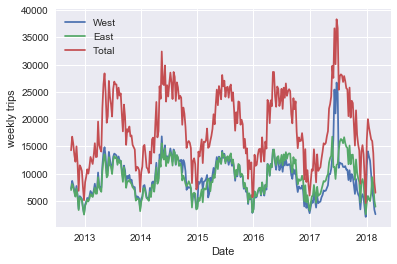

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()  # plot styling
import numpy as np

data.resample('W', how='sum').plot()
plt.ylabel('weekly trips');

In [20]:
pivoted = data.pivot_table(['East', 'West'],
                           index=data.index.date,
                           columns=data.index.hour,
                           fill_value=0)
pivoted.head()

East                                    ... West                 \
Date         0  1  2  3  4   5   6    7    8    9  ...   14   15   16   17   
2012-10-03    9  6  1  3  1  10  50   95  146  104 ...   77   72  133  192   
2012-10-04   11  0  6  3  1  11  51   89  134   94 ...   63   73  114  154   
2012-10-05    7  4  3  2  2   7  37  101  119   81 ...   63   80  120  144   
2012-10-06    7  5  2  2  1   2  15   16   47   55 ...   89  115  107  107   
2012-10-07    5  5  1  2  2   3   8   12   26   36 ...  126  122  132  118   

                                     
Date         18  19  20  21  22  23  
2012-10-03  122  59  29  25  24   5  
2012-10-04  137  57  27  31  25  11  
2012-10-05  107  42  27  11  10  16  
2012-10-06   41  40  25  18  14  15  
2012-10-07   68  26  19  12   9   5  

[5 rows x 48 columns]

In [23]:
X = pivoted.values
X.shape
type(X)

numpy.ndarray

In [12]:
from sklearn.decomposition import PCA
Xpca = PCA(0.9).fit_transform(X)
Xpca.shape

(1975, 3)

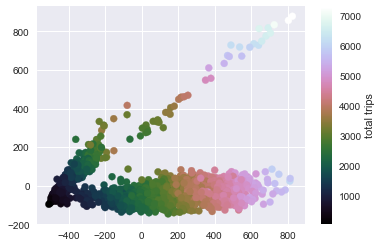

In [15]:
total_trips = X.sum(1)
plt.scatter(Xpca[:, 0], Xpca[:, 1], c=total_trips,
            cmap='cubehelix')
plt.colorbar(label='total trips');

/Users/jeanne/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/jeanne/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/jeanne/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/jeanne/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprec

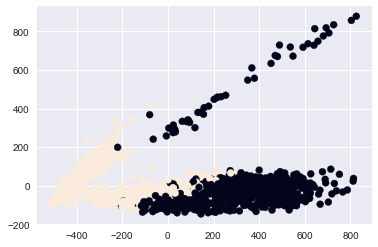

In [16]:
from sklearn.mixture import GMM
gmm = GMM(2, covariance_type='full', random_state=0)
gmm.fit(Xpca)
cluster_label = gmm.predict(Xpca)
plt.scatter(Xpca[:, 0], Xpca[:, 1], c=cluster_label);

In [17]:
pivoted['Cluster'] = cluster_label
data = data.join(pivoted['Cluster'], on=data.index.date)
data.head()

,West,East,Total,Cluster
Date,,,,
2012-10-03 00:00:00,4.0,9.0,13.0,0
2012-10-03 01:00:00,4.0,6.0,10.0,0
2012-10-03 02:00:00,1.0,1.0,2.0,0
2012-10-03 03:00:00,2.0,3.0,5.0,0
2012-10-03 04:00:00,6.0,1.0,7.0,0


In [18]:
by_hour = data.groupby(['Cluster', data.index.time]).mean()
by_hour.head()

West      East      Total
Cluster                                        
0       00:00:00  5.210199  6.457711  11.667910
        01:00:00  2.601990  2.899254   5.501244
        02:00:00  1.912935  1.827114   3.740050
        03:00:00  1.736318  1.407960   3.144279
        04:00:00  4.980100  3.584577   8.564677

/Users/jeanne/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """


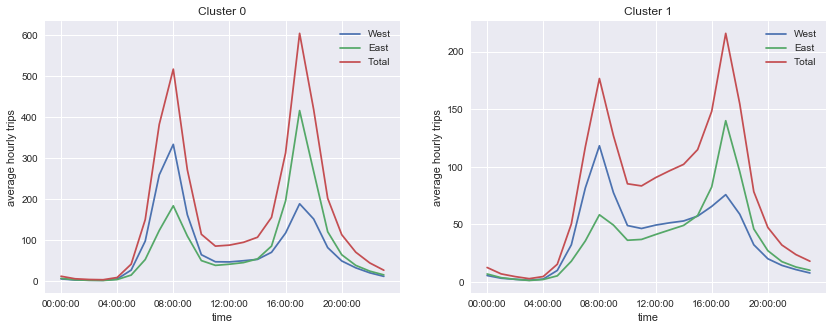

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
hourly_ticks = 4 * 60 * 60 * np.arange(6)

for i in range(2):
    by_hour.ix[i].plot(ax=ax[i], xticks=hourly_ticks)
    ax[i].set_title('Cluster {0}'.format(i))
    ax[i].set_ylabel('average hourly trips')